<a href="https://colab.research.google.com/github/charu1717/Emart/blob/main/apidata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance scipy pandas matplotlib numpy --quiet


In [2]:
!python portfolio_optimization_sharpe.py


python3: can't open file '/content/portfolio_optimization_sharpe.py': [Errno 2] No such file or directory


In [2]:
# Only run once in Colab to install required packages
!pip install yfinance scipy pandas matplotlib numpy --quiet

# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

plt.rcParams["figure.dpi"] = 120



In [16]:
import yfinance as yf
import pandas as pd

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "JPM", "JNJ", "XOM", "PG", "NVDA"]
benchmark = "SPY"
start_date = "2010-01-01"
end_date = "2023-01-01"

# Initialize empty DataFrame
adj_close = pd.DataFrame()

# Download each ticker individually with auto_adjust=False
for t in tickers + [benchmark]:
    data = yf.download(t, start=start_date, end=end_date, progress=False, auto_adjust=False)
    adj_close[t] = data['Adj Close']  # Now 'Adj Close' exists

# Separate stocks and benchmark
stocks = adj_close[tickers]
benchmark_data = adj_close[benchmark]

# Preview
stocks.head()


,AAPL,MSFT,GOOGL,AMZN,META,JPM,JNJ,XOM,PG,NVDA
Date,,,,,,,,,,
2010-01-04,6.424604,23.173344,15.576998,6.6950,NaN,28.690958,40.675068,38.213123,38.685673,0.423854
2010-01-05,6.435712,23.180830,15.508403,6.7345,NaN,29.246695,40.203426,38.362339,38.698334,0.430043
2010-01-06,6.333344,23.038572,15.117456,6.6125,NaN,29.407377,40.530426,38.693901,38.514774,0.432794
2010-01-07,6.321637,22.798977,14.765527,6.5000,NaN,29.989914,40.241158,38.572342,38.305916,0.424313
2010-01-08,6.363663,22.956219,14.962369,6.6760,NaN,29.916256,40.379490,38.417595,38.255276,0.425230


In [17]:
# Calculate daily returns
returns = stocks.pct_change().dropna()
benchmark_returns = benchmark_data.pct_change().dropna()

# Preview
returns.head()


,AAPL,MSFT,GOOGL,AMZN,META,JPM,JNJ,XOM,PG,NVDA
Date,,,,,,,,,,
2012-05-21,0.058260,0.016399,0.022835,0.019921,-0.109861,-0.029263,0.001894,0.006996,-0.002047,0.017384
2012-05-22,-0.007678,0.000336,-0.021674,-0.012746,-0.089039,0.046140,0.000788,-0.001097,-0.003786,-0.012205
2012-05-23,0.024399,-0.021842,0.014414,0.009056,0.032258,0.007350,-0.003936,0.001098,-0.012035,0.024712
2012-05-24,-0.009184,-0.001374,-0.009517,-0.009389,0.032188,-0.008464,0.007022,0.006948,0.002885,-0.026528
2012-05-25,-0.005360,-0.000344,-0.020094,-0.010918,-0.033909,-0.013836,-0.009350,-0.006416,-0.001278,0.023947


In [18]:
import numpy as np
from scipy.optimize import minimize

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    returns = np.dot(weights, mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (returns - risk_free_rate) / volatility
    return returns, volatility, sharpe_ratio

# Negative Sharpe ratio (for minimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

# Constraint: sum of weights = 1
def check_sum(weights):
    return np.sum(weights) - 1


In [19]:
# Annualized mean returns and covariance
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
num_assets = len(stocks.columns)
risk_free_rate = 0.01  # 1% annual

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': check_sum})
bounds = tuple((0, 1) for _ in range(num_assets))  # No shorting

# Run optimization
optimized = minimize(neg_sharpe_ratio, num_assets * [1./num_assets],
                     args=(mean_returns, cov_matrix, risk_free_rate),
                     method='SLSQP', bounds=bounds, constraints=constraints)

# Get optimal weights
opt_weights = optimized.x


In [20]:
import matplotlib.pyplot as plt

# Portfolio daily returns using optimized weights
portfolio_daily_returns = returns @ opt_weights

# Cumulative returns
portfolio_cum_returns = (1 + portfolio_daily_returns).cumprod()
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# Performance metrics
portfolio_return, portfolio_volatility, portfolio_sharpe = portfolio_performance(opt_weights, mean_returns, cov_matrix)
benchmark_annual_return = benchmark_returns.mean() * 252
benchmark_annual_vol = benchmark_returns.std() * (252 ** 0.5)
benchmark_sharpe = (benchmark_annual_return - 0.01) / benchmark_annual_vol

# Print results
print("Optimized Portfolio Weights:")
for t, w in zip(stocks.columns, opt_weights):
    print(f"{t}: {w:.4f}")

print(f"\nPortfolio annual return: {portfolio_return:.2%}")
print(f"Portfolio annual volatility: {portfolio_volatility:.2%}")
print(f"Portfolio Sharpe Ratio: {portfolio_sharpe:.2f}")

print(f"\nBenchmark (SPY) annual return: {benchmark_annual_return:.2%}")
print(f"Benchmark (SPY) annual volatility: {benchmark_annual_vol:.2%}")
print(f"Benchmark (SPY) Sharpe Ratio: {benchmark_sharpe:.2f}")



Optimized Portfolio Weights:
AAPL: 0.0400
MSFT: 0.0827
GOOGL: 0.0000
AMZN: 0.0547
META: 0.0000
JPM: 0.0682
JNJ: 0.3441
XOM: 0.0000
PG: 0.1195
NVDA: 0.2908

Portfolio annual return: 25.71%
Portfolio annual volatility: 20.73%
Portfolio Sharpe Ratio: 1.19

Benchmark (SPY) annual return: 12.84%
Benchmark (SPY) annual volatility: 17.61%
Benchmark (SPY) Sharpe Ratio: 0.67


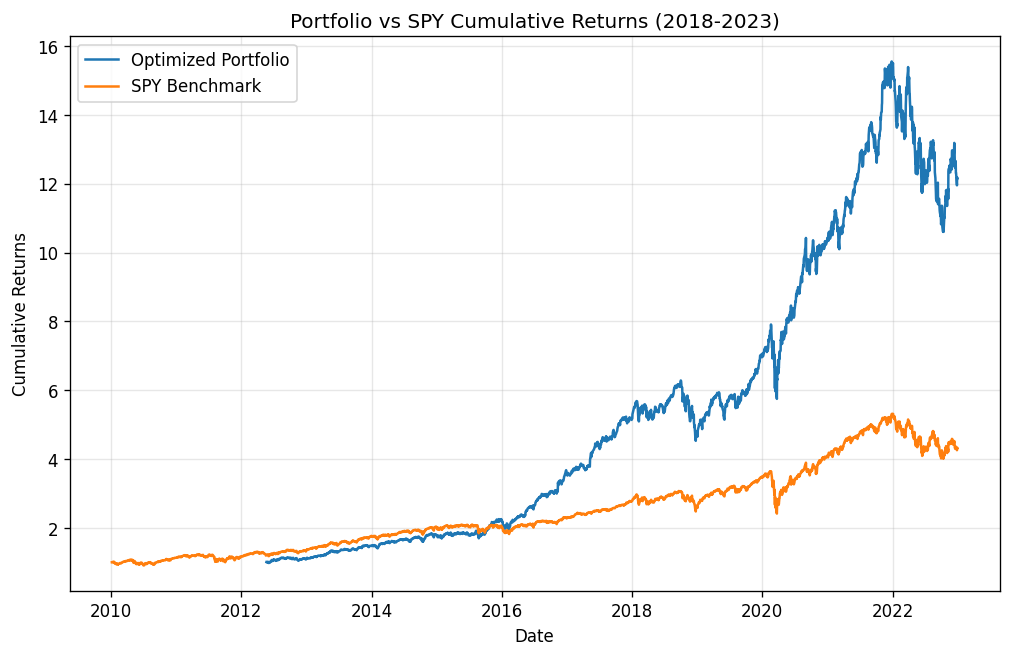

In [21]:
plt.figure(figsize=(10,6))
plt.plot(portfolio_cum_returns, label="Optimized Portfolio")
plt.plot(benchmark_cum_returns, label="SPY Benchmark")
plt.title("Portfolio vs SPY Cumulative Returns (2018-2023)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


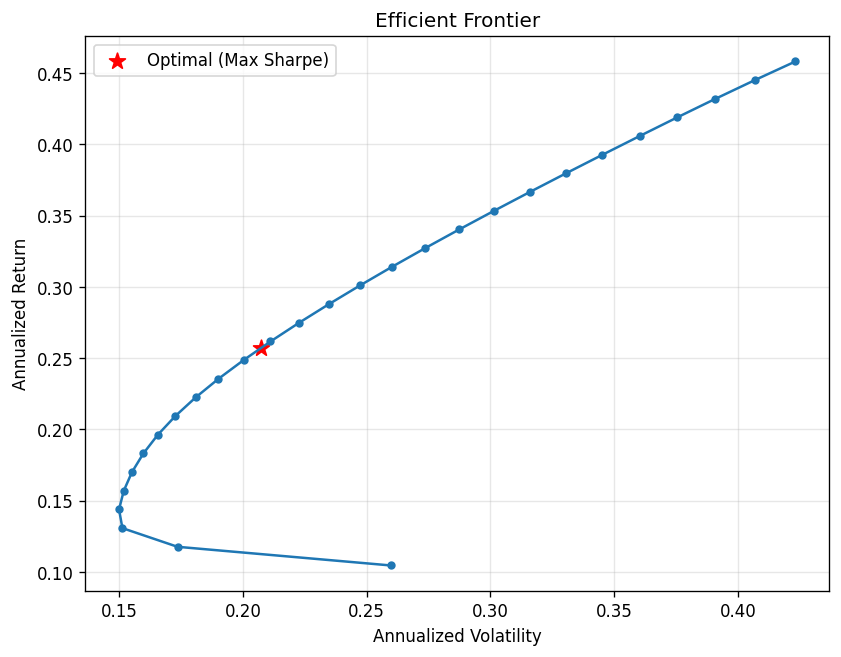

In [22]:
from scipy.optimize import minimize

# Function to generate efficient frontier
def generate_efficient_frontier(mean_returns, cov_matrix, num_assets, returns_range):
    results = []
    bounds = tuple((0, 1) for _ in range(num_assets))

    for target_return in returns_range:
        # Constraints: sum of weights = 1 and portfolio return = target_return
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target_return}
        ]

        # Minimize portfolio volatility for given target return
        res = minimize(lambda w: np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))),
                       num_assets * [1./num_assets],
                       method='SLSQP',
                       bounds=bounds,
                       constraints=constraints)

        if res.success:
            vol = np.sqrt(np.dot(res.x.T, np.dot(cov_matrix, res.x)))
            results.append((target_return, vol, res.x))

    return results

# Generate efficient frontier
returns_range = np.linspace(min(mean_returns)*0.5, max(mean_returns)*1.2, 40)
ef_results = generate_efficient_frontier(mean_returns, cov_matrix, num_assets, returns_range)

ef_rets = [r for r, v, w in ef_results]
ef_vols = [v for r, v, w in ef_results]

# Plot Efficient Frontier
plt.figure(figsize=(8,6))
plt.plot(ef_vols, ef_rets, '-o', markersize=4)
plt.scatter(portfolio_volatility, portfolio_return, marker='*', color='red', s=100, label='Optimal (Max Sharpe)')
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [23]:
import pandas as pd
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
tickers = sp500['Symbol'].tolist()


In [24]:
# Existing DataFrame
stocks.head()


,AAPL,MSFT,GOOGL,AMZN,META,JPM,JNJ,XOM,PG,NVDA
Date,,,,,,,,,,
2010-01-04,6.424604,23.173344,15.576998,6.6950,NaN,28.690958,40.675068,38.213123,38.685673,0.423854
2010-01-05,6.435712,23.180830,15.508403,6.7345,NaN,29.246695,40.203426,38.362339,38.698334,0.430043
2010-01-06,6.333344,23.038572,15.117456,6.6125,NaN,29.407377,40.530426,38.693901,38.514774,0.432794
2010-01-07,6.321637,22.798977,14.765527,6.5000,NaN,29.989914,40.241158,38.572342,38.305916,0.424313
2010-01-08,6.363663,22.956219,14.962369,6.6760,NaN,29.916256,40.379490,38.417595,38.255276,0.425230


In [25]:
new_tickers = ["TSLA", "NFLX", "NVDA", "BABA", "DIS"]

for t in new_tickers:
    data = yf.download(t, start=start_date, end=end_date, progress=False, auto_adjust=False)
    stocks[t] = data['Adj Close']  # Add new column to existing DataFrame

stocks.head()

,AAPL,MSFT,GOOGL,AMZN,META,JPM,JNJ,XOM,PG,NVDA,TSLA,NFLX,BABA,DIS
Date,,,,,,,,,,,,,,
2010-01-04,6.424604,23.173344,15.576998,6.6950,NaN,28.690958,40.675068,38.213123,38.685673,0.423854,NaN,7.640000,NaN,27.475878
2010-01-05,6.435712,23.180830,15.508403,6.7345,NaN,29.246695,40.203426,38.362339,38.698334,0.430043,NaN,7.358571,NaN,27.407339
2010-01-06,6.333344,23.038572,15.117456,6.6125,NaN,29.407377,40.530426,38.693901,38.514774,0.432794,NaN,7.617143,NaN,27.261692
2010-01-07,6.321637,22.798977,14.765527,6.5000,NaN,29.989914,40.241158,38.572342,38.305916,0.424313,NaN,7.485714,NaN,27.270256
2010-01-08,6.363663,22.956219,14.962369,6.6760,NaN,29.916256,40.379490,38.417595,38.255276,0.425230,NaN,7.614286,NaN,27.313097


In [26]:
additional_assets = ["SPY", "QQQ", "TLT"]  # ETFs
for t in additional_assets:
    data = yf.download(t, start=start_date, end=end_date, progress=False, auto_adjust=False)
    stocks[t] = data['Adj Close']

stocks.head()


,AAPL,MSFT,GOOGL,AMZN,META,JPM,JNJ,XOM,PG,NVDA,TSLA,NFLX,BABA,DIS,SPY,QQQ,TLT
Date,,,,,,,,,,,,,,,,,
2010-01-04,6.424604,23.173344,15.576998,6.6950,NaN,28.690958,40.675068,38.213123,38.685673,0.423854,NaN,7.640000,NaN,27.475878,85.515640,40.440395,57.593914
2010-01-05,6.435712,23.180830,15.508403,6.7345,NaN,29.246695,40.203426,38.362339,38.698334,0.430043,NaN,7.358571,NaN,27.407339,85.742004,40.440395,57.965889
2010-01-06,6.333344,23.038572,15.117456,6.6125,NaN,29.407377,40.530426,38.693901,38.514774,0.432794,NaN,7.617143,NaN,27.261692,85.802353,40.196476,57.189938
2010-01-07,6.321637,22.798977,14.765527,6.5000,NaN,29.989914,40.241158,38.572342,38.305916,0.424313,NaN,7.485714,NaN,27.270256,86.164589,40.222603,57.286160
2010-01-08,6.363663,22.956219,14.962369,6.6760,NaN,29.916256,40.379490,38.417595,38.255276,0.425230,NaN,7.614286,NaN,27.313097,86.451302,40.553650,57.260494


In [27]:
# Save the DataFrame to a CSV file
adj_close.to_csv("portfolio_data.csv", index=True)  # index=True keeps the dates as the first column


In [28]:
from google.colab import files
files.download("portfolio_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>